我想把过去14天的藻密度和叶绿素a浓度，不仅仅作为target，也作为feature。那么代码应该如何修改？

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列,增加特征选择
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性并添加L1正则化
feature_importance = {}
l1_lambda = 0.01  # L1正则化系数

for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 添加L1正则化项
        l1_penalty = l1_lambda * np.abs(spearman_corr)
        
        # 综合评分 = 0.35*相关系数 + 0.25*互信息 + 0.25*最大滞后相关 - 0.15*L1惩罚项
        composite_score = 0.35 * abs(spearman_corr) + 0.25 * mi_score + 0.25 * abs(max_lag_corr) - 0.15 * l1_penalty
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag,
            'l1_penalty': l1_penalty
        }

# 只选择最重要的特征(阈值筛选)
importance_threshold = 0.3
filtered_features = {}

for target in target_cols:
    filtered_features[target] = [
        feature for feature, metrics in feature_importance[target].items()
        if metrics['composite_score'] > importance_threshold
    ]

# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]  # 只保留前10个最重要的特征
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag'],
            'L1惩罚': round(metrics['l1_penalty'], 3)
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 10影响因子(添加L1正则化后):")
print(results_df.to_string(index=False))



各目标变量的Top 10影响因子(添加L1正则化后):
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)  L1惩罚
 density_mean_y     temperature 0.453         0.561  0.450   0.580         7 0.006
 density_mean_y min_temperature 0.405         0.546  0.282   0.577         4 0.005
 density_mean_y max_temperature 0.399         0.533  0.267   0.585         3 0.005
 density_mean_y          oxygen 0.362        -0.440  0.329  -0.505        15 0.004
 density_mean_y              TN 0.350        -0.442  0.316  -0.468         4 0.004
 density_mean_y    conductivity 0.349        -0.412  0.401  -0.420         5 0.004
 density_mean_y              pH 0.279         0.335  0.306   0.342         1 0.003
 density_mean_y             aqi 0.219        -0.351  0.078  -0.309         1 0.004
 density_mean_y        aqiLevel 0.211        -0.330  0.095  -0.288         1 0.003
 density_mean_y              TP 0.205         0.272  0.216   0.224         1 0.003
density_lower_y     temperature 0.380         0.465  0.382

请你按照建议修改代码：

我可以帮你修改代码，在模型训练过程中增加藻密度特征的权重。主要有以下几种方法：

1. 在损失函数中为藻密度相关特征添加额外权重
2. 在数据预处理时对藻密度特征进行特殊缩放
3. 在模型结构中添加特征权重层

以下是具体的代码修改建议：

```python:root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/07-TCN-单独计算藻密度-dropout-better+his-density-03.ipynb
# 修改损失函数，为藻密度特征添加更大权重
class WeightedHuberLoss(nn.Module):
    def __init__(self, density_weight=2.0):
        super(WeightedHuberLoss, self).__init__()
        self.base_criterion = nn.HuberLoss()
        self.density_weight = density_weight

    def forward(self, pred, target):
        # 对藻密度预测赋予更大权重
        base_loss = self.base_criterion(pred, target)
        return base_loss * self.density_weight

# ... 其他代码保持不变 ...

def main():
    try:
        # ... 前面的代码保持不变 ...
        
        # 使用加权损失函数替换原有的损失函数
        criterion = WeightedHuberLoss(density_weight=2.0)  # 可以调整权重值
        
        # ... 后面的代码保持不变 ...
```

```python:同文件
# 在TCNModel类中添加特征权重机制
class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        
        # 添加特征权重层
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        
        # ... 其他初始化代码保持不变 ...

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        out = self.tcn(weighted_x)
        
        # ... 其他前向传播代码保持不变 ...
```

```python:同文件
# 在数据预处理函数中修改藻密度特征的缩放
def preprocess_data(df, sequence_length, max_prediction_step=7):
    # ... 前面的代码保持不变 ...
    
    # 对藻密度特征进行特殊缩放
    density_features = ['density_mean_y', 'density_upper_y', 'density_lower_y']
    
    # 使用不同的缩放器分别处理藻密度特征和其他特征
    density_scaler = MinMaxScaler(feature_range=(0.2, 1.0))  # 给予更大的值范围
    other_scaler = MinMaxScaler(feature_range=(0, 0.8))
    
    # 分别缩放
    df_density = df[density_features]
    df_others = df[list(set(all_features) - set(density_features))]
    
    df_density_scaled = pd.DataFrame(
        density_scaler.fit_transform(df_density),
        columns=density_features,
        index=df.index
    )
    
    df_others_scaled = pd.DataFrame(
        other_scaler.fit_transform(df_others),
        columns=df_others.columns,
        index=df.index
    )
    
    # 合并缩放后的数据
    df_scaled = pd.concat([df_density_scaled, df_others_scaled], axis=1)
    
    # ... 后面的代码保持不变 ...
```

这些修改的主要作用是：

1. `WeightedHuberLoss`：通过自定义损失函数，直接增加藻密度预测误差的权重，使模型在训练时更注重优化藻密度预测。

2. `TCNModel`中的特征权重：为每个输入特征添加可学习的权重参数，模型可以自动学习调整不同特征的重要性。

3. 预处理中的特殊缩放：通过给藻密度特征更大的值范围，间接增加其在模型学习中的重要性。

你可以选择使用其中一种或多种方法的组合。建议从较小的权重值开始尝试（如1.5-2.0），然后根据模型表现逐步调整。过大的权重可能会导致模型过度关注藻密度特征，忽视其他有用的环境特征。

2024-11-18 09:52:06,389 - INFO - Successfully loaded data file
2024-11-18 09:52:06,409 - INFO - 开始加载数据并预处理...
2024-11-18 09:52:06,500 - INFO - 环境特征数量: 10
2024-11-18 09:52:06,517 - INFO - 环境特征: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-18 09:52:06,518 - INFO - 历史特征: ['density_mean_y', 'density_upper_y', 'density_lower_y', 'chla_mean', 'chla_upper', 'chla_lower']
2024-11-18 09:52:06,874 - INFO - 输入特征维度: 16
2024-11-18 09:52:06,885 - INFO - 
训练提前1天预报模型
2024-11-18 09:56:45,116 - INFO - Epoch 10/200, Average Loss: 0.1410
2024-11-18 09:56:52,060 - INFO - Epoch 20/200, Average Loss: 0.0583
2024-11-18 09:56:59,194 - INFO - Epoch 30/200, Average Loss: 0.0231
2024-11-18 09:57:06,398 - INFO - Epoch 40/200, Average Loss: 0.0104
2024-11-18 09:57:13,770 - INFO - Epoch 50/200, Average Loss: 0.0077
2024-11-18 09:57:22,156 - INFO - Epoch 60/200, Average Loss: 0.0053
2024-11-18 09:57:30,455 - INFO - Epoch 70/200, Average L

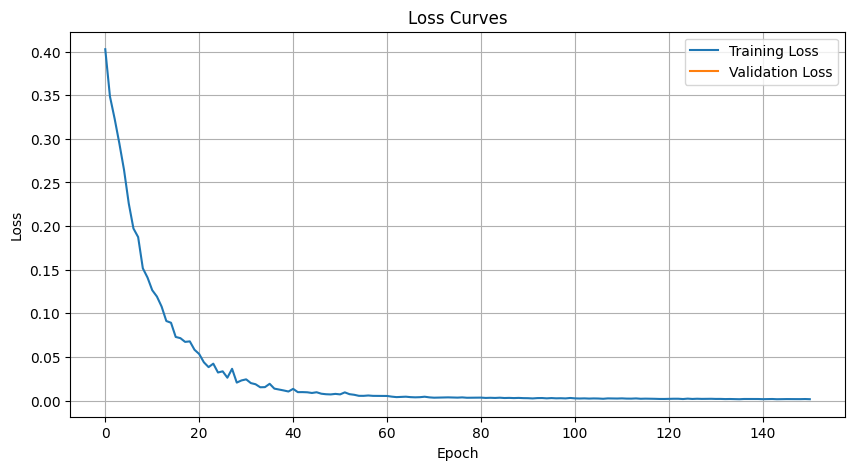

2024-11-18 09:58:37,770 - INFO - Final training loss: 0.0016
2024-11-18 09:58:37,946 - INFO - 提前1天预报 - RMSE: 0.1390, MAE: 0.1177
2024-11-18 09:58:37,947 - INFO - 
训练提前2天预报模型
2024-11-18 09:58:46,309 - INFO - Epoch 10/200, Average Loss: 0.1427
2024-11-18 09:58:54,970 - INFO - Epoch 20/200, Average Loss: 0.0618
2024-11-18 09:59:04,071 - INFO - Epoch 30/200, Average Loss: 0.0256
2024-11-18 09:59:14,080 - INFO - Epoch 40/200, Average Loss: 0.0195
2024-11-18 09:59:25,121 - INFO - Epoch 50/200, Average Loss: 0.0132
2024-11-18 09:59:36,829 - INFO - Epoch 60/200, Average Loss: 0.0076
2024-11-18 09:59:51,429 - INFO - Epoch 70/200, Average Loss: 0.0072
2024-11-18 10:00:06,427 - INFO - Epoch 80/200, Average Loss: 0.0052
2024-11-18 10:00:18,770 - INFO - Epoch 90/200, Average Loss: 0.0048
2024-11-18 10:00:30,368 - INFO - Epoch 100/200, Average Loss: 0.0036
2024-11-18 10:00:42,701 - INFO - Epoch 110/200, Average Loss: 0.0035
2024-11-18 10:00:55,014 - INFO - Epoch 120/200, Average Loss: 0.0032
2024-11

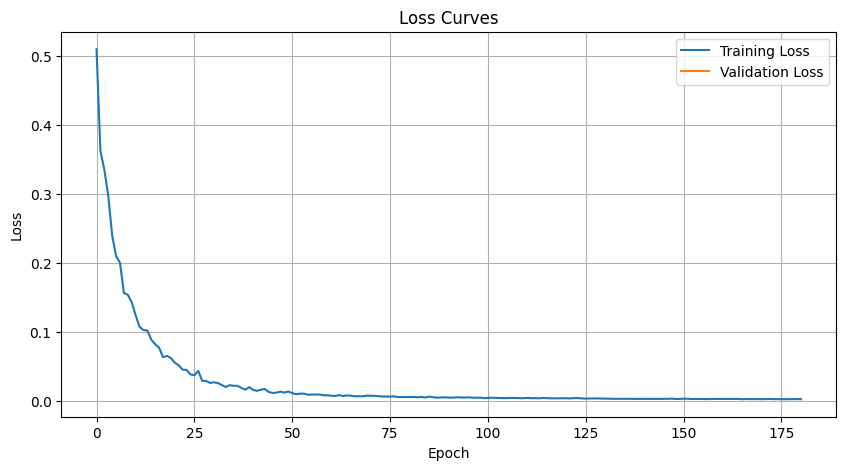

2024-11-18 10:01:44,242 - INFO - Final training loss: 0.0021
2024-11-18 10:01:44,281 - INFO - 提前2天预报 - RMSE: 0.0812, MAE: 0.0680
2024-11-18 10:01:44,282 - INFO - 
训练提前3天预报模型
2024-11-18 10:01:51,743 - INFO - Epoch 10/200, Average Loss: 0.1559
2024-11-18 10:01:59,197 - INFO - Epoch 20/200, Average Loss: 0.0669
2024-11-18 10:02:06,789 - INFO - Epoch 30/200, Average Loss: 0.0327
2024-11-18 10:02:14,903 - INFO - Epoch 40/200, Average Loss: 0.0202
2024-11-18 10:02:23,596 - INFO - Epoch 50/200, Average Loss: 0.0100
2024-11-18 10:02:32,143 - INFO - Epoch 60/200, Average Loss: 0.0079
2024-11-18 10:02:41,254 - INFO - Epoch 70/200, Average Loss: 0.0070
2024-11-18 10:02:48,778 - INFO - Epoch 80/200, Average Loss: 0.0052
2024-11-18 10:02:58,092 - INFO - Epoch 90/200, Average Loss: 0.0038
2024-11-18 10:03:05,858 - INFO - Epoch 100/200, Average Loss: 0.0037
2024-11-18 10:03:14,248 - INFO - Epoch 110/200, Average Loss: 0.0037
2024-11-18 10:03:22,930 - INFO - Epoch 120/200, Average Loss: 0.0030
2024-11

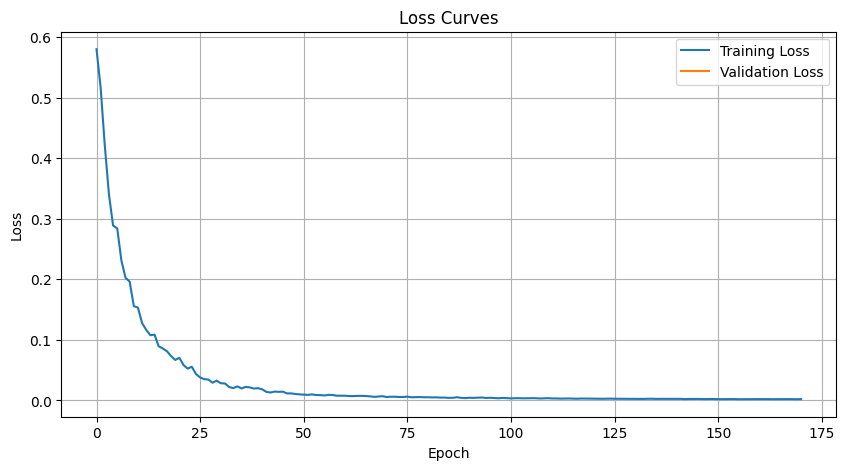

2024-11-18 10:04:10,995 - INFO - Final training loss: 0.0022
2024-11-18 10:04:11,070 - INFO - 提前3天预报 - RMSE: 0.0887, MAE: 0.0724
2024-11-18 10:04:11,071 - INFO - 
训练提前4天预报模型
2024-11-18 10:04:20,839 - INFO - Epoch 10/200, Average Loss: 0.0950
2024-11-18 10:04:30,948 - INFO - Epoch 20/200, Average Loss: 0.0461
2024-11-18 10:04:40,574 - INFO - Epoch 30/200, Average Loss: 0.0187
2024-11-18 10:04:49,279 - INFO - Epoch 40/200, Average Loss: 0.0129
2024-11-18 10:04:59,225 - INFO - Epoch 50/200, Average Loss: 0.0092
2024-11-18 10:05:10,160 - INFO - Epoch 60/200, Average Loss: 0.0065
2024-11-18 10:05:21,178 - INFO - Epoch 70/200, Average Loss: 0.0055
2024-11-18 10:05:31,462 - INFO - Epoch 80/200, Average Loss: 0.0044
2024-11-18 10:05:41,059 - INFO - Epoch 90/200, Average Loss: 0.0041
2024-11-18 10:05:54,654 - INFO - Epoch 100/200, Average Loss: 0.0033
2024-11-18 10:06:05,743 - INFO - Epoch 110/200, Average Loss: 0.0028
2024-11-18 10:06:16,185 - INFO - Epoch 120/200, Average Loss: 0.0027
2024-11

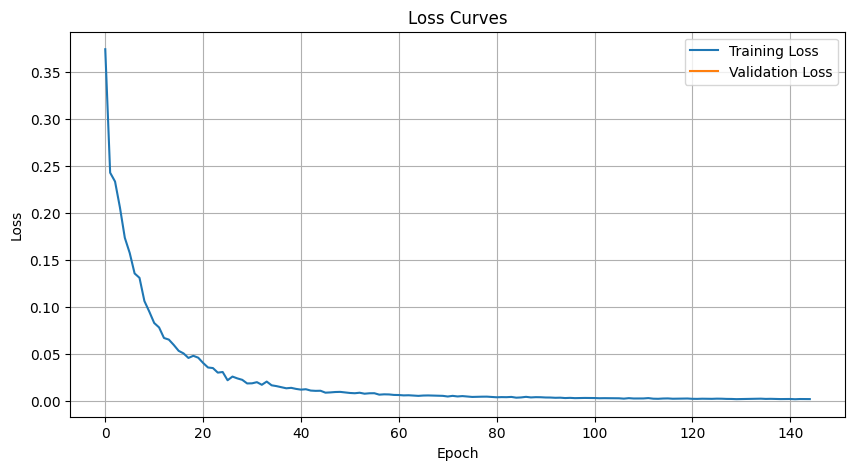

2024-11-18 10:06:42,010 - INFO - Final training loss: 0.0021
2024-11-18 10:06:42,083 - INFO - 提前4天预报 - RMSE: 0.1123, MAE: 0.0908
2024-11-18 10:06:42,084 - INFO - 
训练提前5天预报模型
2024-11-18 10:06:52,852 - INFO - Epoch 10/200, Average Loss: 0.1047
2024-11-18 10:07:05,322 - INFO - Epoch 20/200, Average Loss: 0.0369
2024-11-18 10:07:16,378 - INFO - Epoch 30/200, Average Loss: 0.0238
2024-11-18 10:07:26,849 - INFO - Epoch 40/200, Average Loss: 0.0136
2024-11-18 10:07:36,969 - INFO - Epoch 50/200, Average Loss: 0.0080
2024-11-18 10:07:47,025 - INFO - Epoch 60/200, Average Loss: 0.0059
2024-11-18 10:07:55,535 - INFO - Epoch 70/200, Average Loss: 0.0057
2024-11-18 10:08:04,386 - INFO - Epoch 80/200, Average Loss: 0.0042
2024-11-18 10:08:13,690 - INFO - Epoch 90/200, Average Loss: 0.0035
2024-11-18 10:08:24,644 - INFO - Epoch 100/200, Average Loss: 0.0032
2024-11-18 10:08:35,644 - INFO - Epoch 110/200, Average Loss: 0.0028
2024-11-18 10:08:45,895 - INFO - Epoch 120/200, Average Loss: 0.0027
2024-11

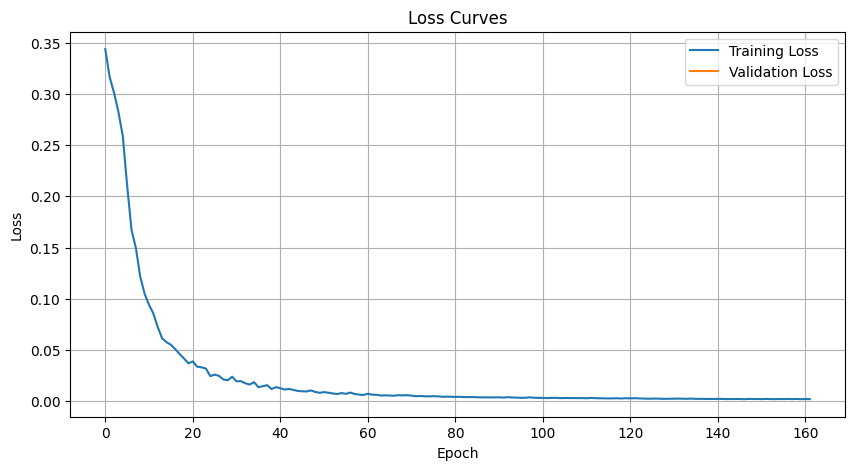

2024-11-18 10:09:25,751 - INFO - Final training loss: 0.0018
2024-11-18 10:09:25,826 - INFO - 提前5天预报 - RMSE: 0.1232, MAE: 0.0967
2024-11-18 10:09:25,827 - INFO - 
训练提前6天预报模型
2024-11-18 10:09:35,829 - INFO - Epoch 10/200, Average Loss: 0.0938
2024-11-18 10:09:45,316 - INFO - Epoch 20/200, Average Loss: 0.0520
2024-11-18 10:09:54,144 - INFO - Epoch 30/200, Average Loss: 0.0238
2024-11-18 10:10:03,080 - INFO - Epoch 40/200, Average Loss: 0.0140
2024-11-18 10:10:13,268 - INFO - Epoch 50/200, Average Loss: 0.0104
2024-11-18 10:10:22,962 - INFO - Epoch 60/200, Average Loss: 0.0074
2024-11-18 10:10:33,167 - INFO - Epoch 70/200, Average Loss: 0.0060
2024-11-18 10:10:43,771 - INFO - Epoch 80/200, Average Loss: 0.0051
2024-11-18 10:10:54,302 - INFO - Epoch 90/200, Average Loss: 0.0050
2024-11-18 10:11:04,694 - INFO - Epoch 100/200, Average Loss: 0.0041
2024-11-18 10:11:14,109 - INFO - Epoch 110/200, Average Loss: 0.0033
2024-11-18 10:11:23,618 - INFO - Epoch 120/200, Average Loss: 0.0030
2024-11

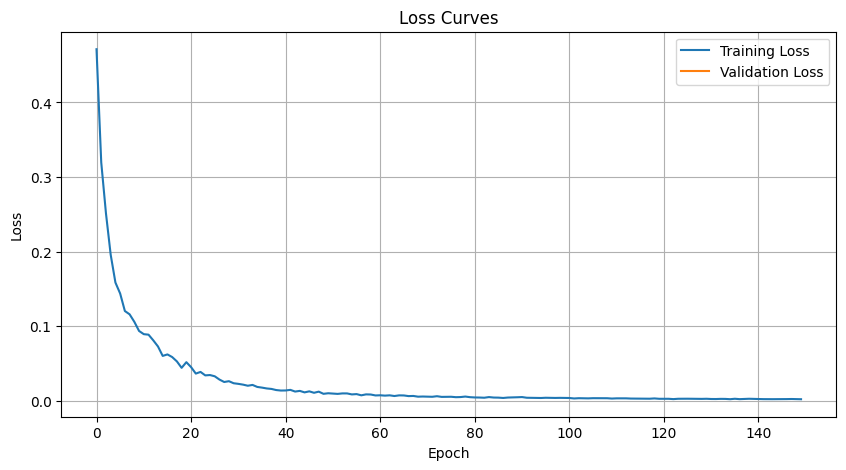

2024-11-18 10:11:54,165 - INFO - Final training loss: 0.0024
2024-11-18 10:11:54,285 - INFO - 提前6天预报 - RMSE: 0.1797, MAE: 0.1505
2024-11-18 10:11:54,286 - INFO - 
训练提前7天预报模型
2024-11-18 10:12:05,012 - INFO - Epoch 10/200, Average Loss: 0.0539
2024-11-18 10:12:15,110 - INFO - Epoch 20/200, Average Loss: 0.0302
2024-11-18 10:12:26,504 - INFO - Epoch 30/200, Average Loss: 0.0188
2024-11-18 10:12:35,221 - INFO - Epoch 40/200, Average Loss: 0.0132
2024-11-18 10:12:43,529 - INFO - Epoch 50/200, Average Loss: 0.0103
2024-11-18 10:12:53,501 - INFO - Epoch 60/200, Average Loss: 0.0071
2024-11-18 10:13:03,348 - INFO - Epoch 70/200, Average Loss: 0.0048
2024-11-18 10:13:13,236 - INFO - Epoch 80/200, Average Loss: 0.0040
2024-11-18 10:13:23,053 - INFO - Epoch 90/200, Average Loss: 0.0038
2024-11-18 10:13:32,570 - INFO - Epoch 100/200, Average Loss: 0.0031
2024-11-18 10:13:43,399 - INFO - Epoch 110/200, Average Loss: 0.0028
2024-11-18 10:13:53,654 - INFO - Epoch 120/200, Average Loss: 0.0027
2024-11

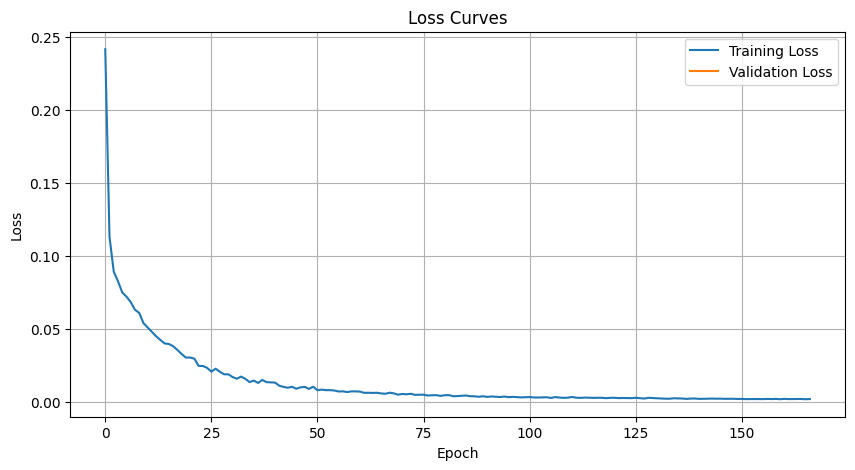

2024-11-18 10:14:45,874 - INFO - Final training loss: 0.0018
2024-11-18 10:14:45,959 - INFO - 提前7天预报 - RMSE: 0.1164, MAE: 0.0936
/tmp/ipykernel_1332/265814939.py:360: UserWarning: Glyph 26102 (\N{CJK UNIFIED IDEOGRAPH-65F6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1332/265814939.py:360: UserWarning: Glyph 38388 (\N{CJK UNIFIED IDEOGRAPH-95F4}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1332/265814939.py:360: UserWarning: Glyph 27493 (\N{CJK UNIFIED IDEOGRAPH-6B65}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1332/265814939.py:360: UserWarning: Glyph 34299 (\N{CJK UNIFIED IDEOGRAPH-85FB}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1332/265814939.py:360: UserWarning: Glyph 23494 (\N{CJK UNIFIED IDEOGRAPH-5BC6}) missing from current font.
  plt.tight_layout()
/tmp/ipykernel_1332/265814939.py:360: UserWarning: Glyph 24230 (\N{CJK UNIFIED IDEOGRAPH-5EA6}) missing from current font.
  plt.tight_layout()
/tmp/ip

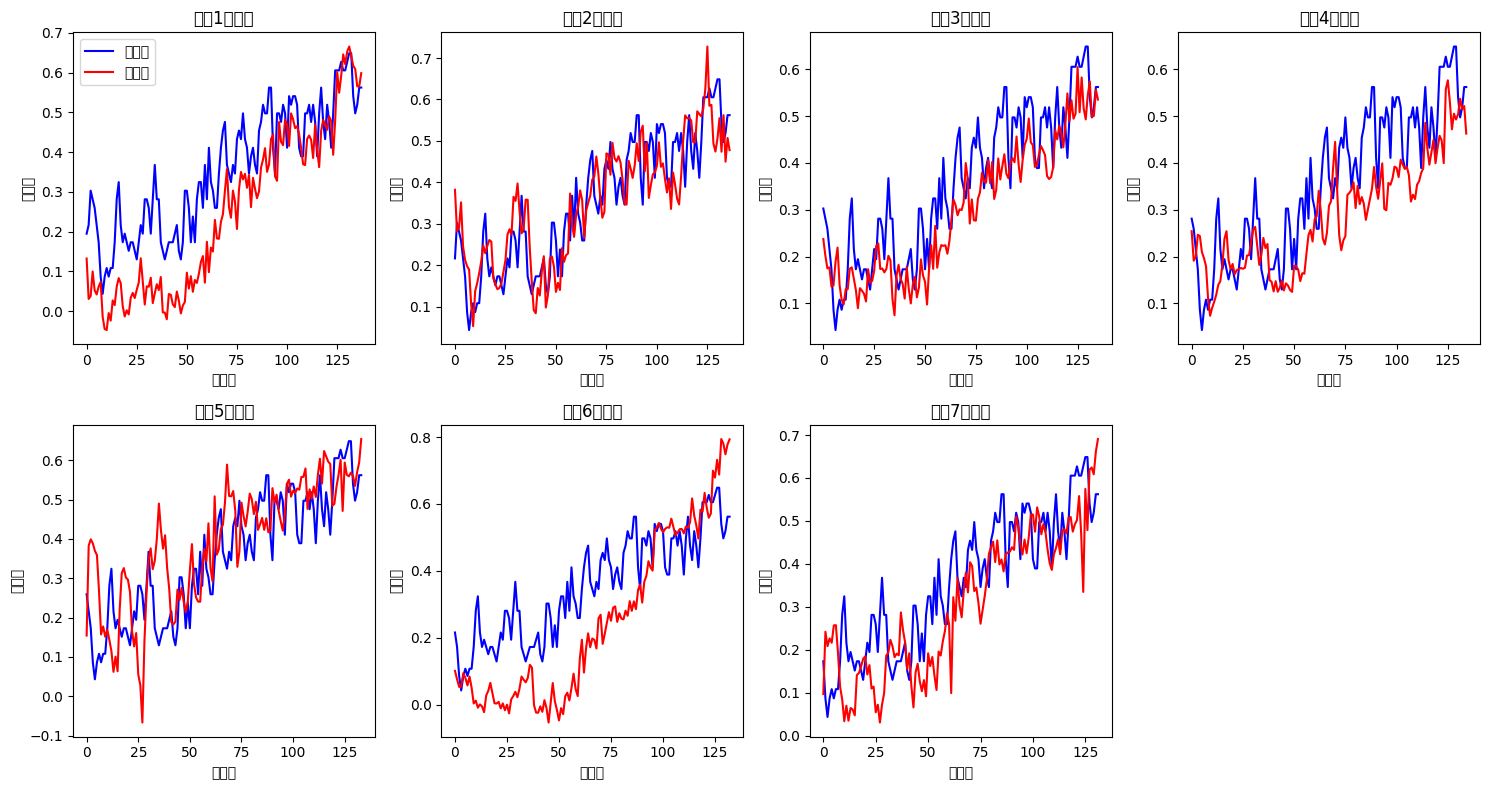

/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 35823 (\N{CJK UNIFIED IDEOGRAPH-8BEF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 24046 (\N{CJK UNIFIED IDEOGRAPH-5DEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38543 (\N{CJK UNIFIED IDEOGRAPH-968F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 38271 (\N{CJK UNIFIED IDEOGRAPH-957F}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/root/.conda/envs/hydro/envs/aie-sdk/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: Us

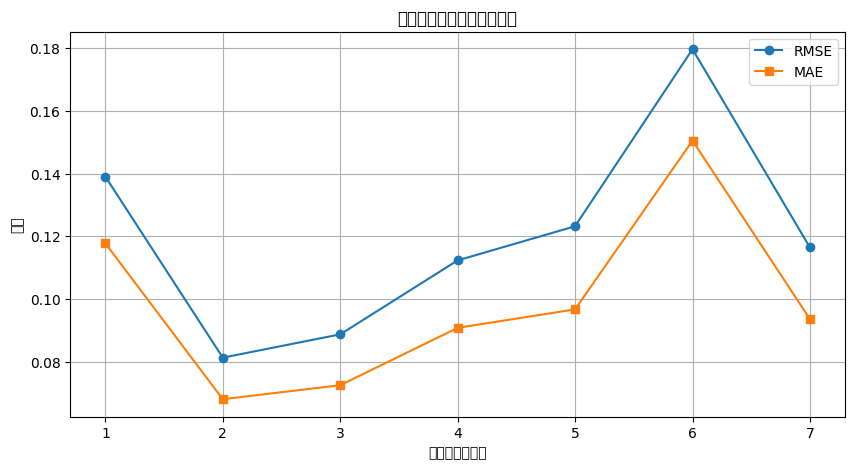

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging
from torch.optim.lr_scheduler import OneCycleLR

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class WeightedHuberLoss(nn.Module):
    def __init__(self, density_weight=2.0):
        super(WeightedHuberLoss, self).__init__()
        self.base_criterion = nn.HuberLoss()
        self.density_weight = density_weight

    def forward(self, pred, target):
        base_loss = self.base_criterion(pred, target)
        return base_loss * self.density_weight

class TemporalBlock(nn.Module):
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = nn.Conv1d(n_inputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm1 = nn.BatchNorm1d(n_outputs)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = nn.Conv1d(n_outputs, n_outputs, kernel_size,
                              stride=stride, padding=padding, dilation=dilation)
        self.batch_norm2 = nn.BatchNorm1d(n_outputs)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.relu = nn.ReLU()

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.batch_norm1(out)
        out = self.relu1(out)
        out = self.dropout1(out)

        out = self.conv2(out)
        out = self.batch_norm2(out)
        out = self.relu2(out)
        out = self.dropout2(out)

        if self.downsample is not None:
            residual = self.downsample(residual)
            
        if out.size(2) != residual.size(2):
            min_len = min(out.size(2), residual.size(2))
            out = out[:, :, :min_len]
            residual = residual[:, :, :min_len]

        return self.relu(out + residual)

class TCNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, kernel_size=3, dropout=0.2):
        super(TCNModel, self).__init__()
        
        # 添加特征权重层
        self.feature_weights = nn.Parameter(torch.ones(input_size))
        
        self.batch_norm = nn.BatchNorm1d(input_size)
        
        # 添加注意力机制，特别关注最近的历史数据
        self.attention = nn.MultiheadAttention(hidden_size, num_heads=4)
        
        # 增加残差连接
        self.residual = nn.Linear(input_size, output_size)
        
        layers = []
        num_channels = [hidden_size] * num_layers
        for i in range(num_layers):
            dilation = 2 ** i
            in_channels = input_size if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            layers.append(TemporalBlock(in_channels, out_channels, kernel_size,
                                      stride=1, dilation=dilation,
                                      padding=(kernel_size-1) * dilation,
                                      dropout=dropout))
        
        self.tcn = nn.Sequential(*layers)
        
        self.fc_layers = nn.Sequential(
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size // 2, output_size)
        )

    def forward(self, x):
        # 应用特征权重
        weighted_x = x * self.feature_weights.view(1, 1, -1)
        
        weighted_x = weighted_x.transpose(1, 2)
        weighted_x = self.batch_norm(weighted_x)
        out = self.tcn(weighted_x)
        
        # 应用注意力机制
        out = out.transpose(1, 2)  # 调整维度以适应注意力层
        attn_out, _ = self.attention(out, out, out)
        out = attn_out[:, -1, :]  # 取最后一个时间步
        
        out = self.fc_layers(out)
        
        # 添加残差连接，特别是对最近的历史数据
        residual = self.residual(weighted_x[:, :, -1])
        out = out + residual
        
        return out

def preprocess_data(df, sequence_length, max_prediction_step=7):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取Top10环境特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    env_features = [feature[0] for feature in sorted_features]
    available_env_features = [f for f in env_features if f in df.columns]
    
    # 添加历史藻密度和叶绿素a特征
    history_features = ['density_mean_y', 'density_upper_y', 'density_lower_y',
                       'chla_mean', 'chla_upper', 'chla_lower']
    all_features = available_env_features + history_features
    
    logging.info(f"环境特征数量: {len(available_env_features)}")
    logging.info(f"环境特征: {available_env_features}")
    logging.info(f"历史特征: {history_features}")
    
    df_features = df[all_features]

    # 对藻密度特征进行特殊缩放
    density_features = ['density_mean_y', 'density_upper_y', 'density_lower_y']
    
    # 使用不同的缩放器分别处理藻密度特征和其他特征
    density_scaler = MinMaxScaler(feature_range=(0.2, 1.0))  # 给予更大的值范围
    other_scaler = MinMaxScaler(feature_range=(0, 0.8))
    
    # 分别缩放
    df_density = df[density_features]
    df_others = df[list(set(all_features) - set(density_features))]
    
    df_density_scaled = pd.DataFrame(
        density_scaler.fit_transform(df_density),
        columns=density_features,
        index=df.index
    )
    
    df_others_scaled = pd.DataFrame(
        other_scaler.fit_transform(df_others),
        columns=df_others.columns,
        index=df.index
    )
    
    # 合并缩放后的数据
    df_scaled = pd.concat([df_density_scaled, df_others_scaled], axis=1)

    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    train_data_dict = {}
    test_data_dict = {}
    
    for step in range(1, max_prediction_step + 1):
        train_sequences = []
        for i in range(len(train_data) - sequence_length - step + 1):
            train_sequences.append(train_data.iloc[i:i+sequence_length+step].values)
        train_sequences = np.array(train_sequences)
        
        test_sequences = []
        for i in range(len(test_data) - sequence_length - step + 1):
            test_sequences.append(test_data.iloc[i:i+sequence_length+step].values)
        test_sequences = np.array(test_sequences)
        
        X_train = train_sequences[:, :sequence_length, :]
        y_train = train_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        X_test = test_sequences[:, :sequence_length, :]
        y_test = test_sequences[:, -1, [all_features.index('density_mean_y')]]
        
        train_data_dict[step] = (X_train, y_train)
        test_data_dict[step] = (X_test, y_test)
    
    return train_data_dict, test_data_dict, density_scaler, all_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs):
    model.train()
    best_loss = float('inf')
    patience = 15
    no_improve = 0
    min_delta = 0.0001
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        total_loss = 0
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            scheduler.step()
            
            total_loss += loss.item()
        
        avg_loss = total_loss / len(train_loader)
        train_losses.append(avg_loss)
        
        if avg_loss < best_loss - min_delta:
            best_loss = avg_loss
            no_improve = 0
        else:
            no_improve += 1
        
        if no_improve >= patience:
            logging.info(f'Early stopping at epoch {epoch}')
            break
            
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss: {avg_loss:.4f}')
    
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    logging.info(f'Final training loss: {train_losses[-1]:.4f}')
    if val_losses:
        logging.info(f'Final validation loss: {val_losses[-1]:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 3
        output_size = 1
        criterion = WeightedHuberLoss(density_weight=2.0)  # 使用加权损失函数
        epochs = 200
        max_prediction_step = 7
        sequence_length = 14

        logging.info("开始加载数据并预处理...")
        train_data_dict, test_data_dict, scaler, features = preprocess_data(
            df, sequence_length, max_prediction_step)
        
        input_size = len(features)  # 输入特征维度会增加
        logging.info(f"输入特征维度: {input_size}")
        
        results = {}
        
        for step in range(1, max_prediction_step + 1):
            logging.info(f"\n训练提前{step}天预报模型")
            
            X_train, y_train = train_data_dict[step]
            X_test, y_test = test_data_dict[step]
            
            train_loader, test_loader = create_dataloaders(
                X_train, y_train, X_test, y_test, batch_size)
            
            model = TCNModel(input_size, hidden_size, num_layers, output_size, 
                           kernel_size=3, dropout=0.2)
            optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.001)
            scheduler = OneCycleLR(optimizer, max_lr=0.0005, epochs=epochs,
                                 steps_per_epoch=len(train_loader),
                                 pct_start=0.3, div_factor=10.0)
            
            train_lstm_model(model, train_loader, criterion, optimizer, scheduler, epochs)
            predictions, targets = evaluate_lstm_model(model, test_loader)
            
            rmse = np.sqrt(mean_squared_error(targets, predictions))
            mae = mean_absolute_error(targets, predictions)
            
            results[step] = {
                'predictions': predictions,
                'targets': targets,
                'rmse': rmse,
                'mae': mae
            }
            
            logging.info(f"提前{step}天预报 - RMSE: {rmse:.4f}, MAE: {mae:.4f}")
        
        plt.figure(figsize=(15, 8))
        for step in range(1, max_prediction_step + 1):
            plt.subplot(2, 4, step)
            plt.plot(results[step]['targets'], label='实际值', color='blue')
            plt.plot(results[step]['predictions'], label='预测值', color='red')
            plt.title(f'提前{step}天预报')
            plt.xlabel('时间步')
            plt.ylabel('藻密度')
            if step == 1:
                plt.legend()
        plt.tight_layout()
        plt.show()
        
        plt.figure(figsize=(10, 5))
        steps = list(results.keys())
        rmse_values = [results[step]['rmse'] for step in steps]
        mae_values = [results[step]['mae'] for step in steps]
        
        plt.plot(steps, rmse_values, 'o-', label='RMSE')
        plt.plot(steps, mae_values, 's-', label='MAE')
        plt.xlabel('预测步长（天）')
        plt.ylabel('误差')
        plt.title('预测误差随预测步长的变化')
        plt.legend()
        plt.grid(True)
        plt.show()

    except Exception as e:
        logging.error(f"程序错误: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()